# 1. Ucitati skup podataka koji je dodeljen vasem timu

#### Ucitati potrebne biblioteke

In [1]:
import numpy as np
import pandas as pd 
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn import metrics

#### Ucitati podatke

In [2]:
bank_marketing = pd.read_csv("../Data/master-data/bank-additional.csv", sep = ";")

#### Razdvojiti set na numericke i kategoricke podatke, razdvojiti i zavisnu varijablu (class/label/output)

In [3]:
categoric_columns = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome"]
numeric_columns = ["age", "duration", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]

label_column = "y"
label_codes = {'yes':1, 'no':0}
label_codes_inverse = {1:'yes', 0:'no'}

# Map from yes/no to 1/0
bank_marketing[label_column] = bank_marketing[label_column].map(label_codes)

# Separate source data
label = bank_marketing[label_column]
categoric_data = bank_marketing.loc[:, categoric_columns].copy()
numeric_data = bank_marketing.loc[:, numeric_columns].copy()

### Kolona __'pdays'__ ima vrednost 999 za zapise koji nemaju vrednosti (jer nemaju prethodnu kampanju). 
To je vrednost koja se koristi kao zamena za NaN vrednosti
Iz razloga sto je ta vrednost dosta veca od svih ostalih vrednosti promenicemo je na -1, kako ne bi imala toliku tezinu u odnosu na ostale vrednosti. U buducem radu trebalo bi napraviti eksperiment sa obe opcije (999 i -1) i videti koja opcija donosi bolje performanse modela. U ovom radu koristice se vrednost -1 NA vrednosti.


In [4]:
numeric_data['pdays'] = numeric_data['pdays'].replace(999, -1)

# 2. Prikazati deskriptivnu statistiku skupa podataka (tipovi podataka, rasponi vrednosti, nedostajuce vrednoti itd..)

### UKUPAN BROJ JEDINSTVENIH VREDNOSTI ZA NUMERICKE KOLONE

In [5]:
print(numeric_data.nunique())

age                67
duration          828
campaign           25
pdays              21
previous            7
emp.var.rate       10
cons.price.idx     26
cons.conf.idx      27
euribor3m         235
nr.employed        12
dtype: int64


### UKUPAN BROJ JEDINSTVENIH VREDNOSTI ZA KATEGORICKE KOLONE

In [6]:
print(categoric_data.nunique())

job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
dtype: int64


### UKUPAN BROJ JEDINSTVENIH VREDNOSTI ZA IZLAZNU ZAVISNU KOLONU

In [7]:
print(label.nunique())

2


### Prikaz tipova podataka za kategoricke kolone

In [8]:
categoric_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 10 columns):
job            4119 non-null object
marital        4119 non-null object
education      4119 non-null object
default        4119 non-null object
housing        4119 non-null object
loan           4119 non-null object
contact        4119 non-null object
month          4119 non-null object
day_of_week    4119 non-null object
poutcome       4119 non-null object
dtypes: object(10)
memory usage: 321.9+ KB


### Prikaza tipova podataka za numericke kolone (i prilagodjavanje istih)

In [9]:
numeric_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 10 columns):
age               4119 non-null int64
duration          4116 non-null float64
campaign          4114 non-null float64
pdays             4119 non-null int64
previous          4117 non-null float64
emp.var.rate      4116 non-null float64
cons.price.idx    4117 non-null float64
cons.conf.idx     4117 non-null float64
euribor3m         4117 non-null float64
nr.employed       4118 non-null object
dtypes: float64(7), int64(2), object(1)
memory usage: 321.9+ KB


Kolona nr.employed ima pogresan tip podataka, pa moramo da proverimo o cemu se radi

In [10]:
numeric_data['nr.employed'].value_counts()

5228.1    1625
5099.1     822
5191       758
5195.8     392
5076.2     164
5017.5     104
4991.6      87
4963.6      83
5008.7      60
5023.5      21
5176.3       1
no           1
Name: nr.employed, dtype: int64

Primecujemo da postoji jedan zapis za pogresnim tipom podataka i ima vrednost 'no'. 
Zamenicemo taj zapis sa najucestalijom vrednoscu te kolone pomocu funkcije MODE, i konvertovacemo tip kolone na float64. 

In [11]:
print('rows with wrong value "no"')
print(numeric_data[numeric_data['nr.employed'] == 'no'].index.values)

nr_employeed_mode = numeric_data['nr.employed'].mode()
numeric_data[numeric_data['nr.employed'] == 'no'].index.values # row 780
numeric_data['nr.employed'] = numeric_data['nr.employed'].replace('no', float(nr_employeed_mode[0])) 
numeric_data = numeric_data.astype({'nr.employed': 'float64'})
numeric_data.dtypes

rows with wrong value "no"
[780]


age                 int64
duration          float64
campaign          float64
pdays               int64
previous          float64
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
dtype: object

#### Prikaz ukupnog broja vrednosti svih kategorija kategorickih podataka u setu

In [12]:
pd.DataFrame(pd.value_counts(categoric_data.values.flatten())).T

,no,nonexistent,yes,cellular,married,telephone,may,university.degree,unknown,single,...,entrepreneur,success,unemployed,housemaid,student,oct,sep,mar,dec,illiterate
0,8503,3523,2841,2652,2509,1467,1378,1264,1230,1153,...,148,142,111,110,82,69,64,48,22,1


### Prikaz tipova podataka za kategoricke kolone

In [13]:
categoric_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 10 columns):
job            4119 non-null object
marital        4119 non-null object
education      4119 non-null object
default        4119 non-null object
housing        4119 non-null object
loan           4119 non-null object
contact        4119 non-null object
month          4119 non-null object
day_of_week    4119 non-null object
poutcome       4119 non-null object
dtypes: object(10)
memory usage: 321.9+ KB


### Prikaz statistike za numericke podatke

In [14]:
numeric_data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4119.000000,4116.000000,4114.000000,4119.000000,4117.000000,4116.000000,4117.000000,4117.000000,4117.000000,4118.000000
mean,40.113620,256.869048,2.534273,-0.733430,0.190430,0.084694,93.579540,-40.486358,4.858993,5166.498057
std,10.313362,254.763913,2.566673,1.532813,0.541904,1.563361,0.579442,4.639840,79.432456,73.669363
min,18.000000,0.000000,1.000000,-1.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000
25%,32.000000,103.000000,1.000000,-1.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,38.000000,181.000000,2.000000,-1.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,317.250000,3.000000,-1.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,88.000000,3643.000000,35.000000,21.000000,6.000000,1.400000,94.767000,1.266000,5099.100000,5228.100000


### Da li je zavisna varijabla/output klasa/labela balansirana?

Prikaz balansiranosti izlazne varijable

0.0    0.890265
1.0    0.109493
Name: y, dtype: float64


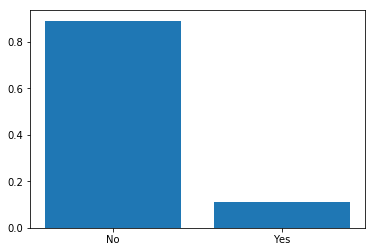

In [15]:
print('Prikaz balansiranosti izlazne varijable\n')
print(label.value_counts() / len(label))

yes_ratio = (label.value_counts()/len(label))[1]
no_ratio = (label.value_counts()/len(label))[0]

x_range = np.arange(2)
balance_class_ratio = [no_ratio, yes_ratio]
fig, ax = plt.subplots()

plt.bar(x_range, balance_class_ratio)
plt.xticks(x_range, ('No', 'Yes'))
plt.show()

### Provera nedostajucih vrednosti 

#### Kategoricki podaci i njihove nedostajuce vrednosti

In [16]:
print('==============   Any null value   ================')
print(categoric_data.isnull().any())
print('==============   Summation   ================')
print(categoric_data.isnull().sum())

==============   Any null value   ================
job            False
marital        False
education      False
default        False
housing        False
loan           False
contact        False
month          False
day_of_week    False
poutcome       False
dtype: bool
==============   Summation   ================
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
poutcome       0
dtype: int64


#### Numericki podaci i njihove nedostajuce vrednosti 

In [17]:
print('==============   Any null value   ================')
print(numeric_data.isnull().any())
print('==============   Summation   ================')
print(numeric_data.isnull().sum())

==============   Any null value   ================
age               False
duration           True
campaign           True
pdays             False
previous           True
emp.var.rate       True
cons.price.idx     True
cons.conf.idx      True
euribor3m          True
nr.employed        True
dtype: bool
==============   Summation   ================
age               0
duration          3
campaign          5
pdays             0
previous          2
emp.var.rate      3
cons.price.idx    2
cons.conf.idx     2
euribor3m         2
nr.employed       1
dtype: int64


#### Nedostajuce vrednosti Output/Zavisne/Labela varijable

In [18]:
print('==============   Summation   ================')
print(label.isnull().sum())


==============   Summation   ================
1


## Imputacija nedostajucih podataka

### Imputacija output klase, zavisnog atributa (pomocu mode() funkcije)

In [19]:
label = label.fillna(label.mode()[0])
print('==============   Summation   ================')
print(label.isnull().sum())

==============   Summation   ================
0


### Imputacija numerickih podataka za srednjim vrednostima atributa (pomocu funkcije mean())

In [20]:
numeric_data = numeric_data.fillna(numeric_data.mean())
print('==============   Summation   ================')
print(numeric_data.isnull().sum())

==============   Summation   ================
age               0
duration          0
campaign          0
pdays             0
previous          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
dtype: int64


### Imputacija kategorickih podataka (kolone koje imaju vrednosti 'unknown')
Postoji nekoliko razlicith pristupa imputacije kategorickih podataka.
Neke od njih cu ovde nabrojati:

0. Brisanje svih redova koji sadze nedostajuce podatke
1. Ignorisati nedostajuce podatke
2. Napraviti model koji predvidja nedostajuce podatke
3. Tretirati nedostajuce podatke kao jos jednu kategoriju
4. Zameniti nedostajuce podatke sa najcescom vrednoscu pomocu funkcije mode()

#### Prvo cemo obrisati redove koji imaju sve NaN vrednosti

In [21]:
categoric_data = categoric_data.dropna(axis='index', how='all')
numeric_data = numeric_data.dropna(axis='index', how='all')

#### Prkaz procenata nedostajucih podataka

In [22]:
categorical_data_missing_values = ['marital', 'education', 'default', 'housing', 'loan']
data_len = len(categoric_data)

unknowns_categorical_data_percentages = pd.DataFrame([], columns = ['UnknownPercentage'], index = categorical_data_missing_values)

for column in categorical_data_missing_values:
	percentage_unknown = categoric_data[column].value_counts()['unknown'] / data_len
	unknowns_categorical_data_percentages.loc[column,:] = {'UnknownPercentage':percentage_unknown*100}
	
unknowns_categorical_data_percentages

,UnknownPercentage
marital,0.267055
education,4.05438
default,19.495
housing,2.54916
loan,2.54916


##### Kolona 'marital' ima jako malo unknown vrednosti, biramo strategiju da zamenimo vrednosti sa najcescom vrednoscu

In [23]:
col_marital_mode = categoric_data['marital'].mode()
categoric_data['marital'] = categoric_data['marital'].replace('unknown', col_marital_mode.values[0])
categoric_data['marital'].value_counts()

married     2520
single      1153
divorced     446
Name: marital, dtype: int64

##### Kolona  'Default' ce zadrzati vrednosti 'unknown' 

##### Vrednosti 'unknown' kolona 'Housing' i 'Loan' ce biti zamenjene pomocu prediktivnog algoritma

In [24]:
print('Housing')
print(categoric_data['housing'].value_counts()) # possible values yes/no/unknown
print('Loan')
print(categoric_data['loan'].value_counts()) # possible values yes/no/unknown

Housing
yes        2175
no         1839
unknown     105
Name: housing, dtype: int64
Loan
no         3349
yes         665
unknown     105
Name: loan, dtype: int64


##### Kolona housing

In [25]:
indexes_not_missing_housing_values = categoric_data[categoric_data['housing'] != 'unknown'].index.values # get training data indexes
x_housing_train = numeric_data[numeric_data.index.isin(indexes_not_missing_housing_values)] # get features for training
x_housing_test = numeric_data[~numeric_data.index.isin(indexes_not_missing_housing_values)] # get features for prediction
Y_housing_train = categoric_data[categoric_data.index.isin(indexes_not_missing_housing_values)]['housing'].map(label_codes) # get labels for training (housing column)

# Fit housing imputation 
alg_housing_imputation = LogisticRegression(random_state=0).fit(x_housing_train, Y_housing_train)
# Predict housing imputation
housing_predicted_imputation = alg_housing_imputation.predict(x_housing_test)

# Create data frame with predicted values
index_missing_housing = categoric_data[categoric_data['housing'] == 'unknown'].index # get indexes of missing categorical rows
imputed_housing_missing_values = pd.DataFrame(data = housing_predicted_imputation, index = index_missing_housing, columns = ['housing']) # create data frame for new imputed values 
imputed_housing_missing_values['housing'] = imputed_housing_missing_values['housing'].map(label_codes_inverse) # map inverse to original data format yes/no

# Impute predicted data into original dataset
categoric_data.loc[imputed_housing_missing_values.index.values, 'housing'] = imputed_housing_missing_values.loc[:,'housing'] # impute to original data set

# Check imputation results
categoric_data['housing'].value_counts()

yes    2280
no     1839
Name: housing, dtype: int64

##### Kolona loan

In [26]:
# Loan imputation section
indexes_not_missing_loan_values = categoric_data[categoric_data['loan'] != 'unknown'].index.values
x_loan_train = numeric_data[numeric_data.index.isin(indexes_not_missing_loan_values)]
x_loan_test = numeric_data[~numeric_data.index.isin(indexes_not_missing_loan_values)]
Y_loan_train = categoric_data[categoric_data.index.isin(indexes_not_missing_loan_values)]['loan'].map(label_codes)

# Fit loan imputation
alg_loan_imputation = LogisticRegression(random_state=0).fit(x_loan_train, Y_loan_train)

# Predict loan imputation
loan_predicted_imputation = alg_loan_imputation.predict(x_loan_test);

# Create new data frame with predicted values
index_missing_loan = categoric_data[categoric_data['loan'] == 'unknown'].index 
imputed_loan_missing_values = pd.DataFrame(data = loan_predicted_imputation, index = index_missing_loan, columns = ['loan'])
imputed_loan_missing_values['loan'] = imputed_loan_missing_values['loan'].map(label_codes_inverse)

# Impute predicted data into original dataset
categoric_data.loc[imputed_loan_missing_values.index.values, 'loan'] = imputed_loan_missing_values.loc[:,'loan']

# Check imputation results 
categoric_data['loan'].value_counts()

no     3454
yes     665
Name: loan, dtype: int64

##### Kolona education tretiracemo podatke kao da klijent namerno nije hteo da da podatke i necemo menjati vrednosti MAR

##### Distribucija kolone AGE

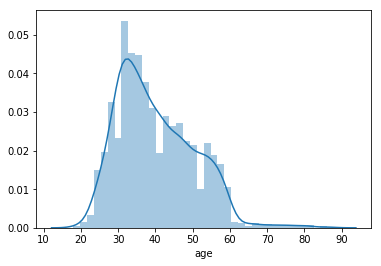

In [27]:
sns.distplot(numeric_data['age']);

##### Distribucija kolone duration

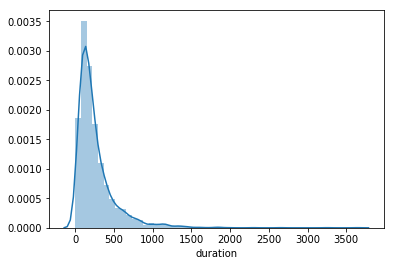

In [28]:
sns.distplot(numeric_data['duration']);

##### Distribucija kolone campaign

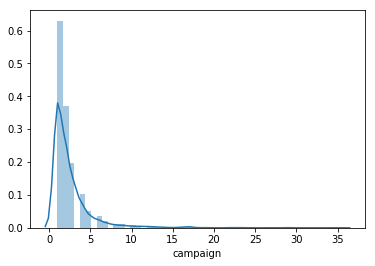

In [29]:
sns.distplot(numeric_data['campaign']);

##### Distribucija kolone emp.var.rate

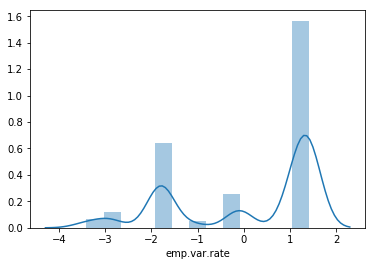

In [30]:
sns.distplot(numeric_data['emp.var.rate'])

#### Prikaz pair plot dijagrama za numericke podatke (analiza zavisnosti izmedju parova podataka)

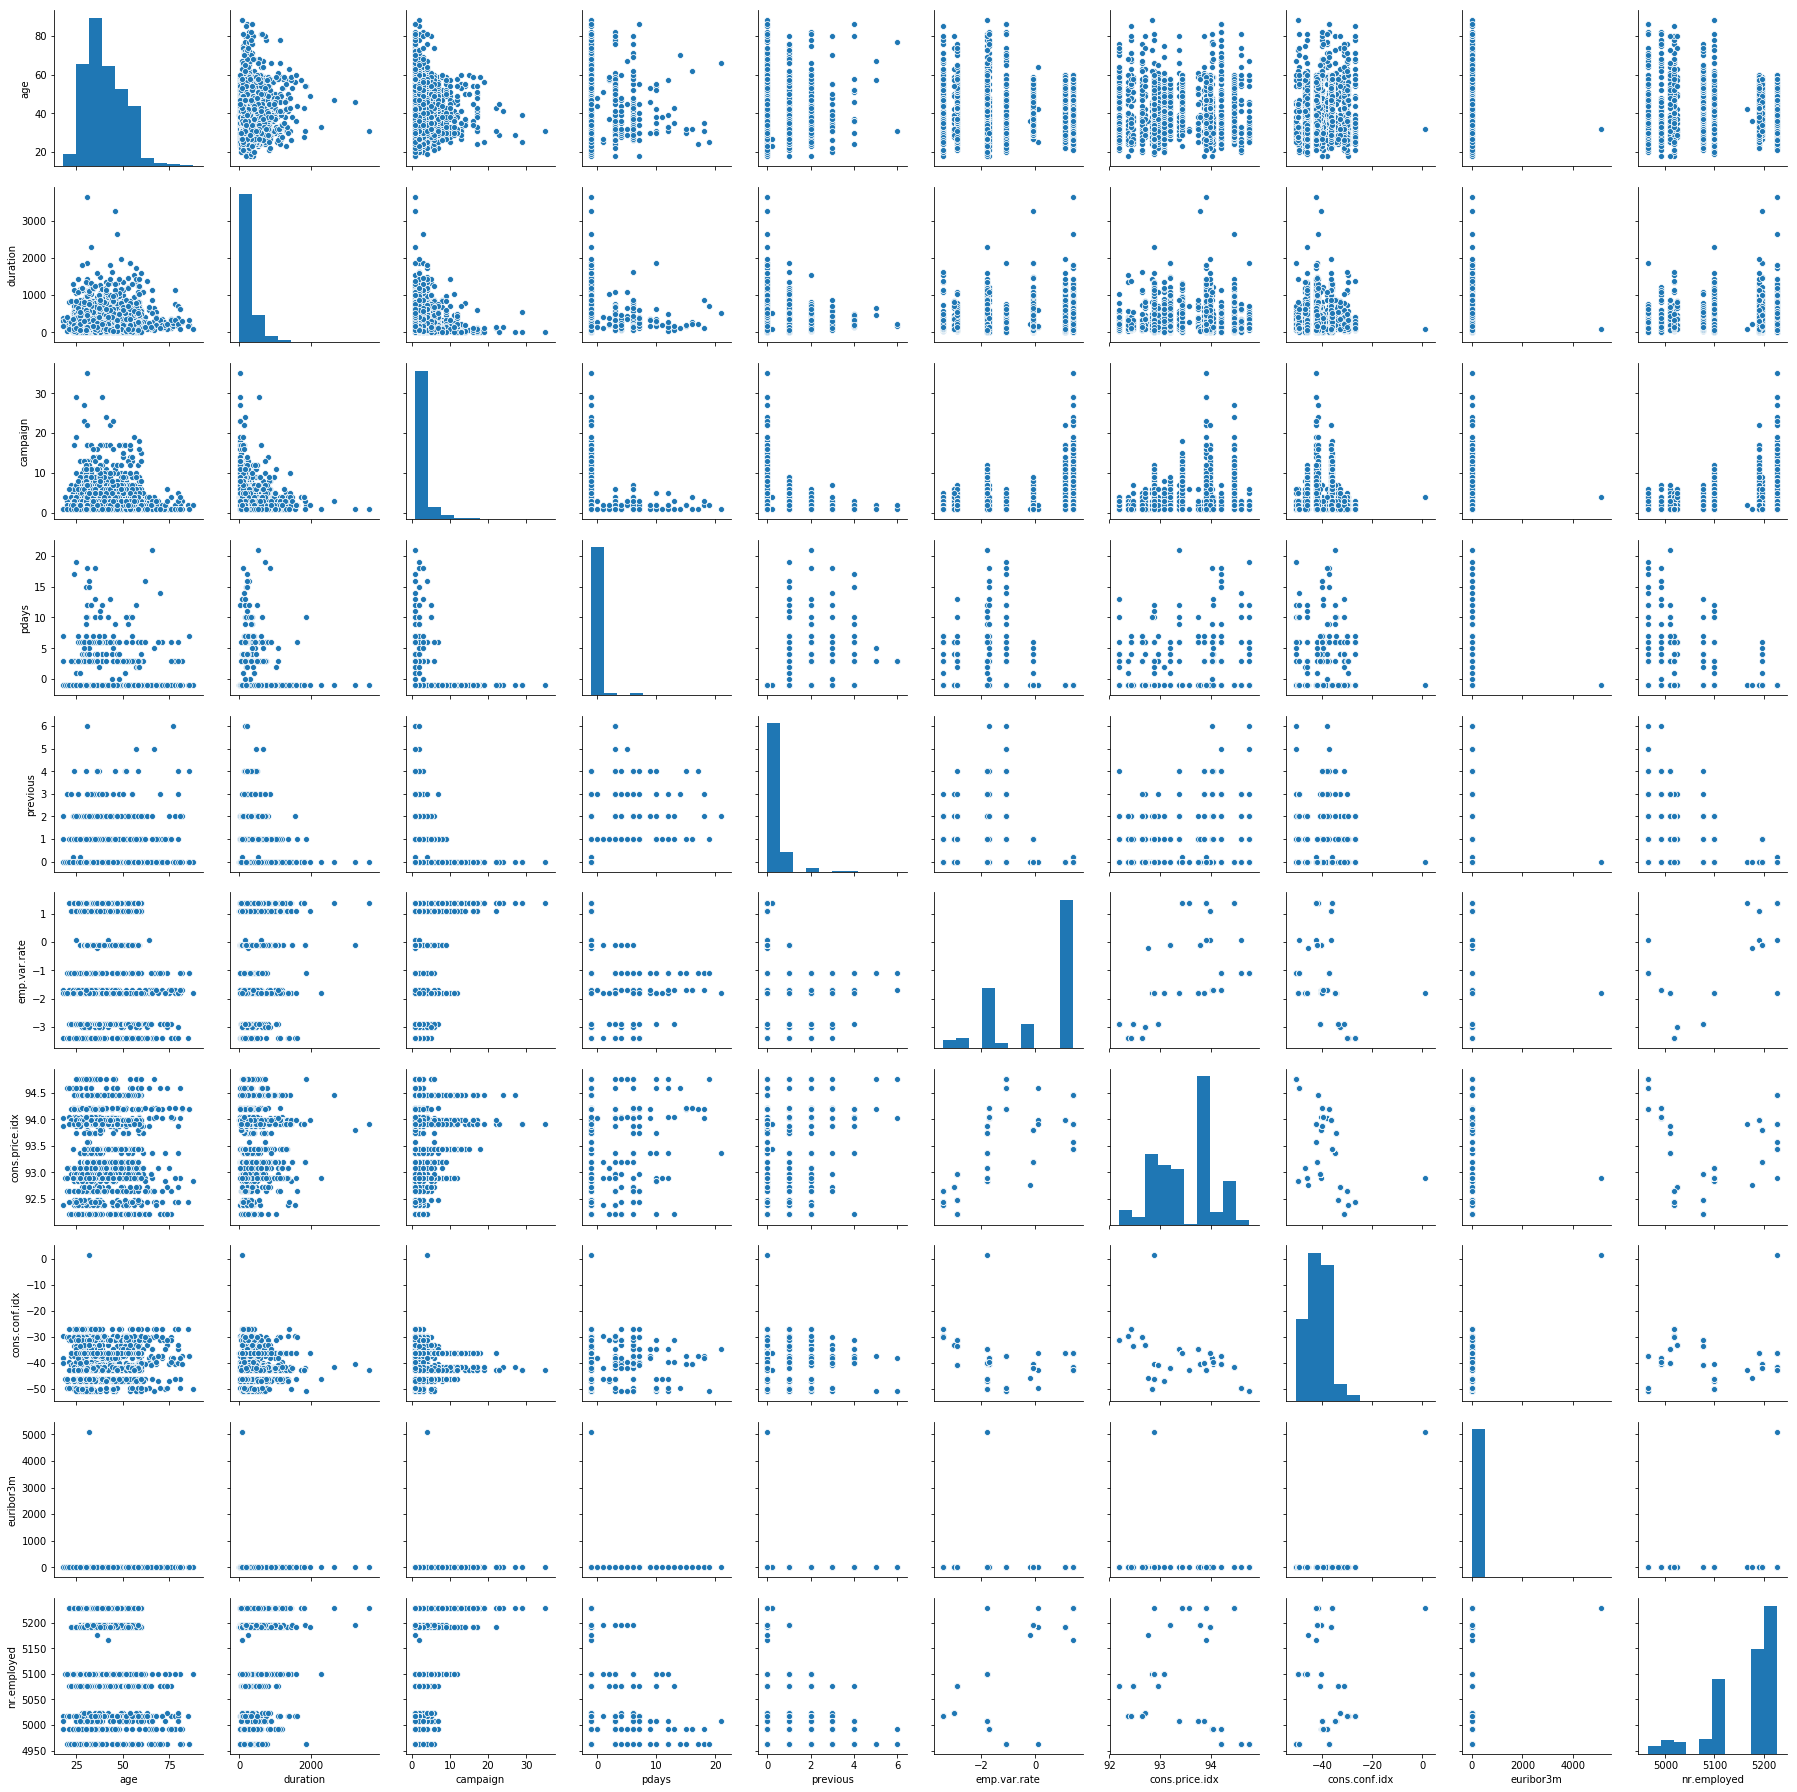

In [31]:
sns.pairplot(numeric_data)

#### Prikaz matrice korelacije

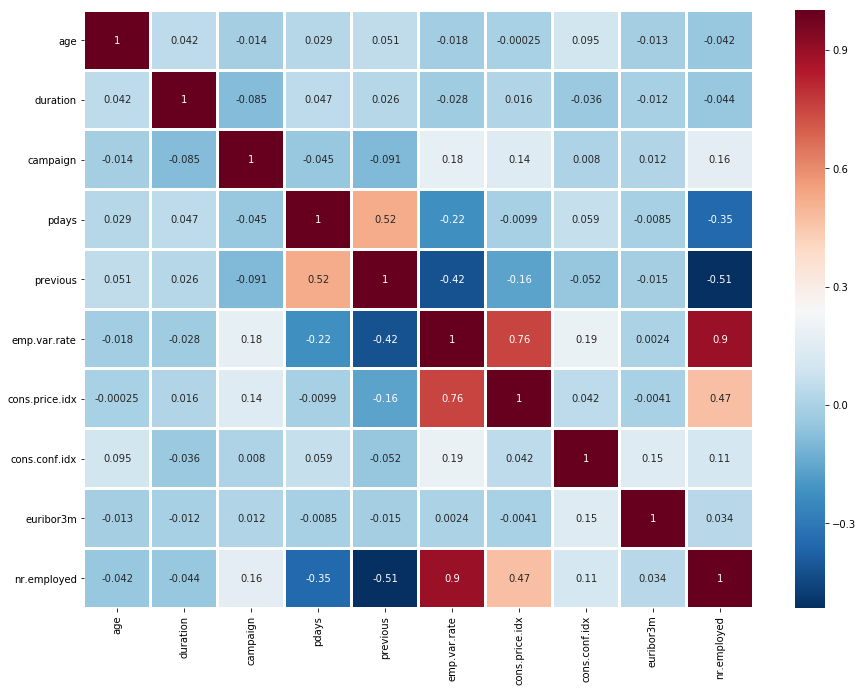

In [32]:
def displayCorrelationMatrix(numeric_data_p):
	
	corr1 = numeric_data_p.corr()
	
	plt.subplots(figsize=(15,11))
	sns.heatmap(corr1, 
	            xticklabels=corr1.columns.values,
	            yticklabels=corr1.columns.values,
				cmap='RdBu_r',
				annot=True,
				linewidth=2)

displayCorrelationMatrix(numeric_data)

# 3. Pripremiti skup podataka tako da bude pogodan za prediktivno modelovanje

### Priprema kategorickih varijabli za prediktivno modelovanje
##### Mozemo koristiti nekoliko strategija:
- Label encoder
- Kombinovanje nivoa
- Dummy coding

Izabracemo dummy_coding strategiju da ne bi doslo do pogresnih zakonitosti kao kod (label encoder-a zbog toga sto su vrednosti sortirane i algoritmi sa regresijom mogu pronaci pogresne paterne/zakonitosti) 

In [33]:
categoric_data = pd.get_dummies(categoric_data)
categoric_data.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


#### Analiza extremnih vrednosti (vrednosti deskriptivne statistike su preuzete iz odeljka 'Prikaz statistike za numericke podatke')

Analiza ekstremnih vrednosti nije egzaktna. Pored tehnika za pronalazenje pomenutih ekstremnih vrednosti kao sto su z-score ili box-plot analiza, ne mozemo u startu oznaciti podatke kao ekstreme bez da logicki ne proverimo raspone vrednosti. Videcemo slucaj sa kolonom 'age' gde nam algoritmi indikuju da postoje ekstremi. Medjutim raspon kodina ja 'razuman' tako da cemo ih mi tretirati kao retke slucajeve u koristicemo ih u analizi. Takodje ukoliko uklonimo retke slucajeve izgubicemo na varijabilitetu a samim tim i na prediktivnoj moci nasih modela. 

- Kolona '__age__' ima minimum 18 i max 88, i bez obzira sto odredjene metode predstavljaju neke kodine kao outlier-e ne mozemo otpisati takve zapise. Iz razloga sto su min i max vrednosti razumne necemo raditi uklanjanje outlier-a
- Kolona '__duration__' ima minimalnu vrednost 0, a maksimalnu 3643 (u sekundama), sto je oko 1h, i ovo bi trebalo dodatno proveriti ali u nasoj zemlji je ogranicenje na 1h sto se poklapa sa maksimalnim trajanjem poziva u ovoj koloni... U pitanju je duzina poslednjeg kontakta.
- Kolona '__campaign__' ima minimalnu vrednosti 1 a maksimalnu vrednost 35. S obzirom da je ovo razuman broj poziva morali bismo da uzmemo u obzir i te vrednosti.
- Kolona '__pdays__' ima minimalnu vrednost -1 a maksimalnu 21 sto smatramo razumnim vrednostima. U pitanju je broj dana od poslednjeg kontakta.
- Kolona '__previous__' ima minimalnu vrednost -1 a maksimalnu 6, sto smatramo razumnim vrednostima. U pitanju ukupan broj kontakata pre ove kampanje
- Kolona '__emp.var.rate__' ima minimalnu vrednost -3.4 i maksimalnu 1.4, sto smatramo razumnim vrednostima. U pitanju je stopa varijacije zaposlenosti. 
- Kolona '__cons.price.idx__' ima minimalnu vrednost 92.201 i maksimalnu 94.767, sto smatramo razumnim vrednostima. U pitanju je index potrosackih cena.
- Kolona '__cons.conf.idx__'  ima minimalnu vrednost -50.80 i maksimalnu 1.266 . Smatramo da ima jedan outlier koji ima z-score veci od 7. U pitanju je indeks poverenja potrosaca.
- Kolona '__euribor.3m__' ima minimalnu vrednost 0.635 i maksimalnu vrednost 5099.100. Smatramo da ima jedan outlier koji z-score veci od 64. U pitanju je Euro Interbank Offered Rate
- Kolona '__nr.employed__' ima minimalnu vrednost 4963.60 i maksimalnu vrednost 5228.10. Nakon box-plot analize i z-core filtera zalkjucili smo da nema ekstremnih vrednosti.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


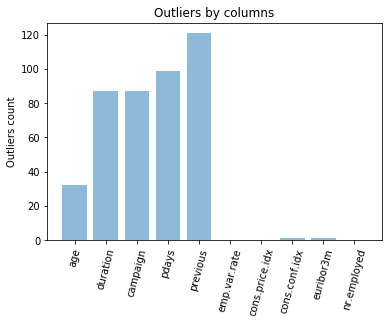

In [34]:
threshold = 3

df_outliers = pd.DataFrame([], columns = ['OutliersCount', 'ColumnName'], index = None )

for column in numeric_data.columns:
	zsc = np.abs(stats.zscore(numeric_data[column]))
	input_array_zsc = np.array(np.where(zsc > threshold))
	outliers = numeric_data[column].ix[numeric_data.index.isin(input_array_zsc[0])]
	df_outliers = df_outliers.append({'OutliersCount' : len(outliers) , 'ColumnName' : column} , ignore_index=True)
    
def displayBarChartForOutliers(df_with_outliers, y_label_name, title_name, y_axis_column_name, x_axis_column_name):
	
	y_axis = df_with_outliers[y_axis_column_name].values
	y_pos = np.arange(len(y_axis))
	x_axis = df_with_outliers[x_axis_column_name].values

	plt.bar(y_pos, x_axis, align='center', alpha=0.5)
	plt.xticks(y_pos, y_axis, rotation=75)
	plt.ylabel(y_label_name)
	plt.title(title_name)
	
	plt.show()

displayBarChartForOutliers(df_outliers, 'Outliers count', 'Outliers by columns', 'ColumnName', 'OutliersCount')


#### Kolona index korisnickog poverenja i ekstremne vrednosti

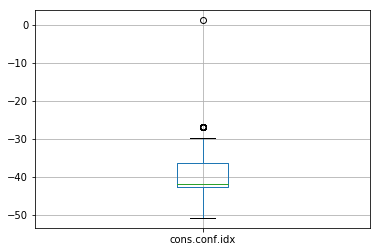

In [35]:
numeric_data.boxplot(column = ['cons.conf.idx'])

In [36]:
np.array(np.where(np.abs(stats.zscore(numeric_data['cons.conf.idx'])) > 7))

array([[780]], dtype=int64)

#### Kolona euribor.3m i ekstremne vrednosti

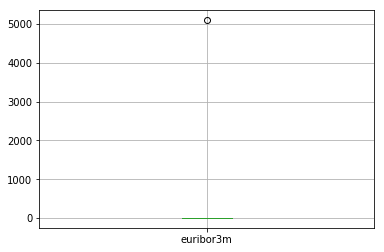

In [37]:
numeric_data.boxplot(column = ['euribor3m'])

In [38]:
np.array(np.where(np.abs(stats.zscore(numeric_data['euribor3m'])) > 63))

array([[780]], dtype=int64)

### Brisanje extremnih vrednosti

In [39]:
numeric_data = numeric_data.drop(780)
categoric_data = categoric_data.drop(780)
label = label.drop(780)

### Grupisanje numerickih i dummy kategorickih varijabli u jedan dataset

In [40]:
data = pd.concat([numeric_data, categoric_data], axis=1, sort=False)

### Normalizacija podataka koriscenjem klase StandardScaler()

In [41]:
scaler = StandardScaler()
# koristim scaler objekat da bih kasnije mogao da radim inverse transform
standard_scaler_transformed = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data = standard_scaler_transformed, columns = data.columns.values)
data_scaled.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,-0.980897,0.903524,-0.208154,-0.173952,-0.351585,-1.206485,-1.185608,-1.241823,-1.332174,-0.914858,...,-0.130542,-0.125646,2.088535,-0.511887,-0.513398,-0.506594,-0.489123,-0.352006,0.411366,-0.188982
1,-0.108178,0.349836,0.571569,-0.173952,-0.351585,0.649497,0.715283,0.891930,0.711443,0.332865,...,-0.130542,-0.125646,2.088535,-0.511887,-0.513398,-0.506594,-0.489123,-0.352006,0.411366,-0.188982
2,-1.465742,-0.117460,-0.598015,-0.173952,-0.351585,0.841495,1.528471,-0.283812,0.773179,0.836571,...,-0.130542,-0.125646,-0.478804,-0.511887,-0.513398,-0.506594,2.044474,-0.352006,0.411366,-0.188982
3,-0.205146,-0.942102,0.181708,-0.173952,-0.351585,0.841495,1.528471,-0.283812,0.771448,0.836571,...,-0.130542,-0.125646,2.088535,-0.511887,-0.513398,-0.506594,-0.489123,-0.352006,0.411366,-0.188982
4,0.667574,-0.781100,-0.598015,-0.173952,-0.351585,-0.118496,-0.655569,-0.327358,0.328337,0.398035,...,-0.130542,-0.125646,-0.478804,1.953554,-0.513398,-0.506594,-0.489123,-0.352006,0.411366,-0.188982


# 4. Analizirajte glane komponente skupa podataka 

Napravicemo jednu funkciju za visuelizaciju odnosa komponenti i kumulativne varijanse koju nose. 
Nakon toga videcemo koliko komponenti nose 98 ili vise varijabiliteta, sto nam moze znaciti u redukovanju dimenzionalnosti, a kasnike i u dodatnom ubrzanju izvrsavanja i mozda povecanja generalizacije odnosno izbegavanja pretreniranja.

In [42]:
def displayPCAVariationPlot(p):
	plt.figure()
	plt.plot(np.cumsum(p.explained_variance_ratio_))
	plt.xlabel('Number of Components')
	plt.ylabel('Variance (%)')
	plt.title('Dataset Explained Variance')
	plt.show()

#### Prikazati varijaciju svih komponenti 

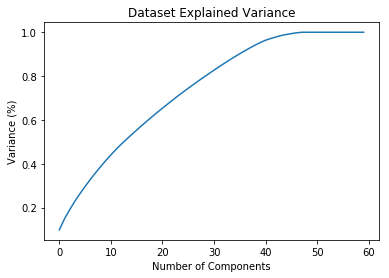

In [43]:
pca_all = PCA().fit(data_scaled)
displayPCAVariationPlot(pca_all)

#### Prikazati varijaciju komponenti koje kumulativno nose 98% varijanse

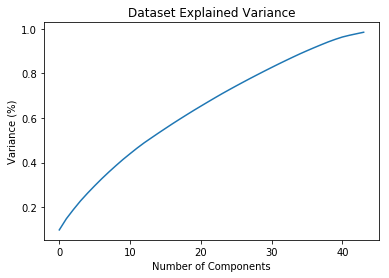

In [44]:
pca_98_percent = PCA(0.98).fit(data_scaled)
displayPCAVariationPlot(pca_98_percent)

In [45]:
print(pca_98_percent.explained_variance_ratio_)
print('Ukupan broj komponeneti: {0}'.format(len(pca_98_percent.explained_variance_ratio_)))

[0.09778492 0.05027751 0.04131838 0.03874765 0.03483325 0.03294131
 0.03170681 0.0300027  0.02869877 0.02776538 0.02586671 0.0253125
 0.02370572 0.02181483 0.02163249 0.02108795 0.02099283 0.0202826
 0.01992076 0.01968721 0.01905099 0.01888588 0.01867768 0.01838289
 0.01764456 0.01742228 0.01703282 0.01684541 0.01646144 0.01630886
 0.01595452 0.01580275 0.01538304 0.01512951 0.01480581 0.01403001
 0.01362091 0.01320654 0.01280346 0.01154169 0.0103602  0.00778726
 0.0068457  0.00672716]
Ukupan broj komponeneti: 44


#### Transformacija podataka i smanjivanje dimenzionalnosti

In [46]:
components_number_98_per_variance = len(pca_98_percent.explained_variance_ratio_)
pca = PCA(n_components = components_number_98_per_variance)
train_data_pca_transformed = pca.fit_transform(data_scaled).copy()
print('Redukovana dimanzionalnost redovi i kolone: {}'.format(train_data_pca_transformed.shape))
train_data_pca_transformed[0,:] # samo prvi red

Redukovana dimanzionalnost redovi i kolone: (4118, 44)


array([ 1.55035577,  1.1710621 , -0.82996334, -2.65640822,  0.25872765,
       -1.26117231, -1.5457961 ,  0.25014905, -0.65051919, -1.36609354,
       -0.19765536, -1.66378877, -1.374999  , -1.06761938,  0.60056255,
        0.0090981 , -0.02135237,  0.19428593,  0.00785972,  1.95076619,
        0.36092182,  0.7359988 , -1.07021175, -0.70997538,  0.05741942,
       -0.15129114, -0.43261003,  0.1069357 ,  0.41309299,  0.33303942,
        0.14727307, -0.23361749,  0.46790235,  0.35039857,  0.18729178,
        0.86721433, -0.5394302 , -0.64211165,  0.82972313, -0.17266659,
       -0.37960099, -0.58977774,  0.2358899 , -0.24009069])

Pomocu PCA transformacije dobijamo na redukciji feature-a a  gubimo na mogucnoscu objasnjivanja kolona.

# 5. Podelite podatke skup podataka na trening i test u odnosu 70:30

In [47]:
data_min_max_scaled = MinMaxScaler().fit_transform(data)

X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.3)

In [48]:
X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(data, label, test_size=0.3)

# 6. Analizirajte klaster model i odredite klastere svake instance, karakterisite dobijene klastere

Za klasterovanje koristicemo K-MEANS++, koji se razlikuje od osnovnog K-MEANS-a jer ne postavlja random inicijalne klastere vec ima posebne proracune i optimizacije. U ranijim experimentima dokazano je da K-MEAN++ moze samo da poboljsa performanse osnovnog algoritma, a u najgorem slucaju da imaju iste perfomanse.

Za odabir broja klastera prikazacemo jedan od nacina koriscenje silhouette_index score-a. 

Nakon toga cemo odraditi treniranje modela prema vec unapred definisanim brojem klastera (u kasnijim zadacima.

Nakon dodeljivanja klastera u nasem dataset-u, videcemo deskriptivnu statistiku za svaki klaster po kolonama posebno.

### Funkcija za prikaz silhoute index score-a, analiza optimalnog broja klastera

Iteration: 0 , Total clusters: 2 , score: 0.1024492445994823
Iteration: 1 , Total clusters: 3 , score: 0.09872156093284536
Iteration: 2 , Total clusters: 4 , score: 0.08441129951060947
Iteration: 3 , Total clusters: 5 , score: 0.07784563992568909
Iteration: 4 , Total clusters: 6 , score: 0.08155613511698852
Iteration: 5 , Total clusters: 7 , score: 0.08448111866862876
Iteration: 6 , Total clusters: 8 , score: 0.09050230626977267
Iteration: 7 , Total clusters: 9 , score: 0.08507113026780987


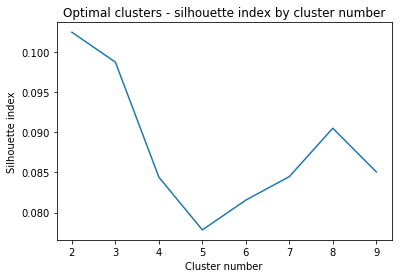

In [49]:
def calculateSilhoueteIndexForClusters(max_clusters):	
	
	silhouette_idex_array = np.array([])
	cluster_array = np.array([])
	for i in range(2,max_clusters):
		kmeans_model = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(data_min_max_scaled)
		labels = kmeans_model.labels_
		sil_idx =  metrics.silhouette_score(data_min_max_scaled, labels, metric='euclidean')
		silhouette_idex_array = np.append(silhouette_idex_array, sil_idx)
		cluster_array = np.append(cluster_array, i)
		print('Iteration: {} , Total clusters: {} , score: {}'.format(i-2,i, sil_idx))
        
	plt.figure()
	plt.plot(cluster_array, silhouette_idex_array)
	plt.xlabel('Cluster number')
	plt.ylabel('Silhouette index') #for each component
	plt.title('Optimal clusters - silhouette index by cluster number')
	plt.show()

calculateSilhoueteIndexForClusters(10)

Najbolji moguci index skor je 1 a najgori moguci je -1. Vrednosti blizu 0 indikuju preklapanje klastera. Negativne vrednosti generaln indikuju da su observacije prikljucene pogresnom klasteru i da su dosta slicnije najbizem klasteru.

U nastavku cemo kreirati model sa 4 klastera (zbog kasnijih zadataka za 4 prediktivna modela):

In [50]:
cluster_n = 4

# Fit
cluster_model = KMeans(n_clusters = cluster_n, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0, n_jobs =-1)
cluster_model.fit(data_scaled)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

#### Prikazacemo centroide

In [51]:
centers_df = pd.DataFrame(cluster_model.cluster_centers_, columns = X_train.columns)
centers_df.head(cluster_n)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0.013989,-0.025938,0.134788,-0.173952,-0.350187,0.700640,0.936760,0.386763,0.714570,0.525966,...,-0.101031,-0.125646,0.063838,-0.024402,-0.086417,0.025224,0.025274,-0.349587,0.409213,-0.188982
1,0.199913,0.212868,-0.289581,4.326766,2.919492,-1.343801,-0.278719,0.470939,-1.502076,-1.911571,...,0.362553,0.948880,-0.007584,0.049859,0.016228,0.074297,-0.136344,-0.028678,-2.430925,4.736517
2,-0.004282,0.020426,-0.197015,-0.169809,0.385279,-1.273134,-0.972433,-0.565698,-1.298584,-1.129434,...,0.203354,0.150255,0.024476,0.059469,-0.007484,-0.053793,-0.022620,0.755361,-0.574413,-0.188982
3,-0.032359,-0.018211,0.084111,-0.173952,-0.351076,0.646104,0.023754,0.092640,0.674138,0.746986,...,-0.130542,-0.125646,-0.082541,-0.036665,0.087635,0.016481,0.012088,-0.352006,0.411366,-0.188982


#### Prikazacemo odnos kolicine pripadnosti redova po klasterima i visuelizovati

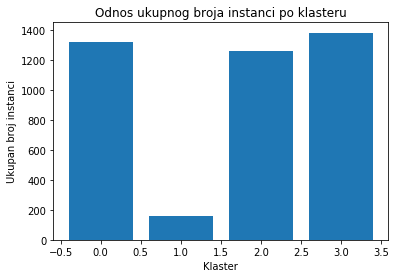

In [52]:
clusters_ratio = np.unique(cluster_model.labels_, return_counts = True) 

def displayCentersCountPlotBarChart(centers_counts, centers_index):
	fig, ax = plt.subplots()
	plt.bar(centers_index, centers_counts)
	plt.xlabel('Klaster')
	plt.ylabel('Ukupan broj instanci')
	plt.title('Odnos ukupnog broja instanci po klasteru')
	plt.show()
	
displayCentersCountPlotBarChart(clusters_ratio[1], clusters_ratio[0])

In [53]:
# Spojiti dataset sa labelama klastera
labels_df = pd.DataFrame(cluster_model.labels_, columns = ['Cluster'])
data_scaled_labeled = pd.concat([data_scaled, labels_df], axis=1, sort=False)

In [54]:
def returnInverseTransformedData(data_scaled_labeled_p):
	features = data_scaled_labeled_p.iloc[:,:-1]
	lbl = pd.DataFrame(data_scaled_labeled_p.iloc[:,-1], columns = ['Cluster']) 
	
	inverse_transformed_data = pd.DataFrame(scaler.inverse_transform(features), columns = features.columns)
	inverse_transformed_data['Cluster'] = lbl.iloc[:,-1]
	return inverse_transformed_data

inverse_transfomed_data = returnInverseTransformedData(data_scaled_labeled)

def getDescriptionForClusters(data_scaled_labeled_p, cluster_number, cluster_centers):
	
	clusters_description = pd.DataFrame([])
	
	for i in range(cluster_number):
		
		desc_internal = data_scaled_labeled_p[data_scaled_labeled_p['Cluster'] == i].describe()
		desc_internal['Cluster'] = i
		center = centers_df.iloc[i:i+1,:]
		center['Cluster'] = i
		desc_internal = desc_internal.append(center)
		clusters_description = clusters_description.append(desc_internal)
		
	return clusters_description

desc_for_cluster = getDescriptionForClusters(inverse_transfomed_data, 4, centers_df)
desc_for_cluster.head(36)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,Cluster
count,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,...,1.320000e+03,1320.000000,1320.000000,1320.000000,1.320000e+03,1320.000000,1320.000000,1320.000000,1320.000000,0
mean,40.259848,250.306719,2.879649,-1.000000,0.000758,1.179913,94.122280,-38.720152,4.860420,5205.222652,...,1.734723e-18,0.211364,0.197727,0.173485,2.143939e-01,0.203030,0.000758,0.999242,0.000000,0
std,9.126101,254.430174,2.996681,0.000000,0.027524,0.307046,0.268142,2.747568,0.272292,21.771059,...,0.000000e+00,0.408430,0.398436,0.378809,4.105568e-01,0.402407,0.027524,0.027524,0.000000,0
min,22.000000,0.000000,1.000000,-1.000000,0.000000,-1.800000,92.893000,-46.200000,0.702000,4991.600000,...,1.734723e-18,0.000000,0.000000,0.000000,-2.775558e-17,0.000000,0.000000,0.000000,0.000000,0
25%,33.000000,99.750000,1.000000,-1.000000,0.000000,1.100000,93.994000,-41.800000,4.857000,5191.000000,...,1.734723e-18,0.000000,0.000000,0.000000,-2.775558e-17,0.000000,0.000000,1.000000,0.000000,0
50%,39.000000,177.000000,2.000000,-1.000000,0.000000,1.100000,93.994000,-36.400000,4.859000,5191.000000,...,1.734723e-18,0.000000,0.000000,0.000000,-2.775558e-17,0.000000,0.000000,1.000000,0.000000,0
75%,47.000000,304.250000,3.000000,-1.000000,0.000000,1.400000,94.465000,-36.400000,4.959000,5228.100000,...,1.734723e-18,0.000000,0.000000,0.000000,-2.775558e-17,0.000000,0.000000,1.000000,0.000000,0
max,60.000000,3253.000000,27.000000,-1.000000,1.000000,1.400000,94.465000,-36.100000,5.045000,5228.100000,...,1.734723e-18,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,0.000000,0
0,0.013989,-0.025938,0.134788,-0.173952,-0.350187,0.700640,0.936760,0.386763,0.714570,0.525966,...,-1.256458e-01,0.063838,-0.024402,-0.086417,2.522381e-02,0.025274,-0.349587,0.409213,-0.188982,0
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,...,1.580000e+02,158.000000,158.000000,158.000000,1.580000e+02,158.000000,158.000000,158.000000,158.000000,1


In [55]:
def showScatterPlotForSomeColumnsMax4Clusters(labels, features, first_column_name, second_column_name):
	
	cluster_map = {0:'g', 1:'b', 2:'r', 3:'y'}
	cluster_color = [cluster_map[i] for i in labels]
	plt.close()
	plt.xlabel(first_column_name)
	plt.ylabel(second_column_name)
	plt.title('Cluster distributions by colors')
	plt.scatter(features.loc[:,first_column_name], features.loc[:,second_column_name], c = cluster_color, label = labels)

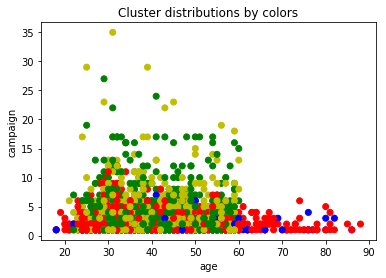

In [56]:
showScatterPlotForSomeColumnsMax4Clusters(inverse_transfomed_data.iloc[:,-1].values, inverse_transfomed_data.iloc[:,:-1], 'age', 'campaign')

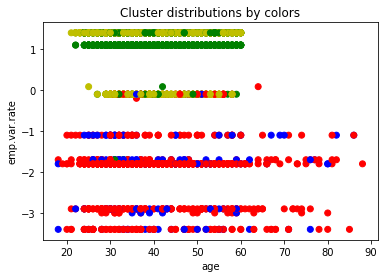

In [57]:
showScatterPlotForSomeColumnsMax4Clusters(inverse_transfomed_data.iloc[:,-1].values, inverse_transfomed_data.iloc[:,:-1], 'age', 'emp.var.rate')

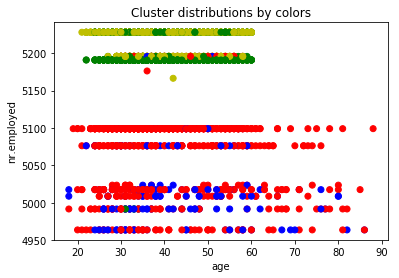

In [58]:
showScatterPlotForSomeColumnsMax4Clusters(inverse_transfomed_data.iloc[:,-1].values, inverse_transfomed_data.iloc[:,:-1], 'age', 'nr.employed')

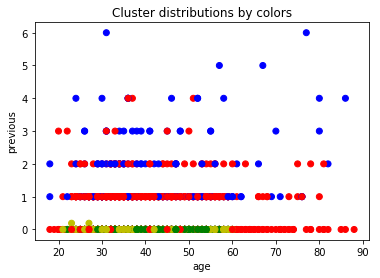

In [59]:
showScatterPlotForSomeColumnsMax4Clusters(inverse_transfomed_data.iloc[:,-1].values, inverse_transfomed_data.iloc[:,:-1], 'age', 'previous')

# 7. Kreirati minimalno 3 prediktivna modela  (sa default parametrima) uporediti ih kros validacijom i ocenite gresku na test setu Minimum 2 mere evaluacije. Koristiti Pipeline

Ideja je da kreiramo 5 prediktivna modela :
   - Logisticku regresiju
   - Naive bayes
   - Random forest
   - Knn 
   - Decesion three
    
I da uporedimo performanse pomocu sledecih ocena:
   - Precision
   - Recall
   - F1 score
   - Accuracy
   
To cemo prvo uraditi na nebalansiranim podacima, a kasnije cemo na balansiranim kako bismo uporedili rezultate.

In [60]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

def doCrossValidation(alg_):
	return cross_validate(alg_, X_train, Y_train, cv=10, n_jobs=-1, return_train_score=True, scoring = ['precision', 'recall','accuracy','f1'])

#### Primer pipeline-a za logisticku regresiju

In [61]:
pipeline_steps_lr = [('minMax', MinMaxScaler()), ('lr', LogisticRegression())] 
pipe_lr = Pipeline(steps = pipeline_steps_lr)
pipe_lr.set_params(lr__random_state = 0)
pipe_lr.set_params(lr__class_weight = 'balanced')
cross_validation_result_lr_pipe = pd.DataFrame(doCrossValidation(pipe_lr))
np.mean(cross_validation_result_lr_pipe)

fit_time           0.107820
score_time         0.006209
test_precision     0.458014
train_precision    0.477096
test_recall        0.818750
train_recall       0.869792
test_accuracy      0.871618
train_accuracy     0.879675
test_f1            0.586551
train_f1           0.616177
dtype: float64

#### Primer pipeline-a za cross validaciju sa naive bayes-om

In [62]:
pipeline_steps_gnb = [('standardScaler', StandardScaler()), ('pca', PCA()), ('gnb', GaussianNB())]
pipe_gnb = Pipeline(steps = pipeline_steps_gnb)
cross_validation_result_gnb_pipe = pd.DataFrame(doCrossValidation(pipe_gnb))
np.mean(cross_validation_result_gnb_pipe)

fit_time           0.044328
score_time         0.006529
test_precision     0.411185
train_precision    0.418591
test_recall        0.565625
train_recall       0.568403
test_accuracy      0.859816
train_accuracy     0.864369
test_f1            0.474402
train_f1           0.482070
dtype: float64

#### Primer pipeline-a za cross validaciju sa random forest algoritmom

In [63]:
pipeline_steps_rndfr = [('minMax', MinMaxScaler()), ('rndf', RandomForestClassifier())]
pipe_rndf = Pipeline(steps = pipeline_steps_rndfr)
pipe_rndf.set_params(rndf__random_state = 0)
pipe_rndf.set_params(rndf__class_weight = 'balanced')
cross_validation_result_rndf_pipe = pd.DataFrame(doCrossValidation(pipe_rndf))
np.mean(cross_validation_result_rndf_pipe)

fit_time           0.475112
score_time         0.025461
test_precision     0.678730
train_precision    1.000000
test_recall        0.275000
train_recall       1.000000
test_accuracy      0.904582
train_accuracy     1.000000
test_f1            0.389363
train_f1           1.000000
dtype: float64

#### Primer pipeline-a za cross validaciju sa knn algoritmom

In [64]:
pipeline_steps_knn = [('standardScaler', StandardScaler()), ('pca', PCA()), ('knn', KNeighborsClassifier())]
pipe_knn = Pipeline(steps = pipeline_steps_knn)
pipe_knn.set_params(knn__n_neighbors=3)
cross_validation_results_knn_pipe = pd.DataFrame(doCrossValidation(pipe_knn))
np.mean(cross_validation_results_knn_pipe)

fit_time           0.077288
score_time         0.157966
test_precision     0.552794
train_precision    0.796072
test_recall        0.306250
train_recall       0.482639
test_accuracy      0.895207
train_accuracy     0.928792
test_f1            0.391454
train_f1           0.600790
dtype: float64

#### Primer pipeline-a za cross validaciju sa decision three algoritmom

In [65]:
pipeline_steps_dthree = [('minMax', MinMaxScaler()), ('dthree', DecisionTreeClassifier())]
pipe_dthree = Pipeline(steps = pipeline_steps_dthree)
pipe_dthree.set_params(dthree__class_weight = 'balanced')
cross_validation_results_dthree = pd.DataFrame(doCrossValidation(pipe_dthree))
np.mean(cross_validation_results_dthree)

fit_time           0.035863
score_time         0.005123
test_precision     0.467022
train_precision    1.000000
test_recall        0.456250
train_recall       1.000000
test_accuracy      0.880638
train_accuracy     1.000000
test_f1            0.459161
train_f1           1.000000
dtype: float64

Mozemo uvideti da je najbolje ocene imao random forest klasifikator

# 8. Promenite minimalno 2 parametra kod najboljeg modela i ocenite gresku na test setu.

Koristicemo Random Forest model jer je on prethodno pokazao najbolje rezultate. 
Promenicemo mu 2 parametra:
- n_estimators
- max_depth

I nakon toga pogledati ocene sa novim parametrima.

In [66]:
pipeline_steps_rndfr2 = [('minMax', MinMaxScaler()), ('rndf', RandomForestClassifier())]
pipe_rndf2 = Pipeline(steps = pipeline_steps_rndfr2)
pipe_rndf2.set_params(rndf__random_state = 0)
pipe_rndf2.set_params(rndf__class_weight = 'balanced')
pipe_rndf2.set_params(rndf__max_depth = 16)
pipe_rndf2.set_params(rndf__n_estimators = 40)
cross_validation_result_rndf_pipe2 = pd.DataFrame(cross_validate(pipe_rndf2, X_train, Y_train, cv=10, n_jobs=-1, return_train_score=True, scoring = ['precision', 'recall','accuracy','f1']))
np.mean(cross_validation_result_rndf_pipe2)


fit_time           0.199251
score_time         0.012827
test_precision     0.652922
train_precision    0.997568
test_recall        0.315625
train_recall       0.996875
test_accuracy      0.904234
train_accuracy     0.999383
test_f1            0.418551
train_f1           0.997220
dtype: float64

Vidimo da su se ocene za neke mere pokvarile a za neke popravile. 
- __F1__ na test podacima je sada bolji (__pre 0.399790, sada 0.441662__) 
- __Accuracy__ na test podacima je sada malo losiji (__pre 0.906314, sada 0.905623__)
- __Recall__ na test podacima je sada bolji (__pre 0.284470, sada 0.337405__)
- __Precision__ na test podacima je sada losiji (__pre 0.689105, sada 0.651397__)

# 9. Testirajte prediktivne modele na atributima koji kumulativno nose 98% varijanse.

U okviru ovog zadatka prikazacemo par nacina kako mozemo da resimo problem. 
PCA analiza nam omogucava najbrze resavanje.
Pomocu algoritma RandomForestClassifier mozemo dobiti informacije o vaznostima atributa

In [67]:
minmax_scaled_data_alg = MinMaxScaler()
minmax_scaled_data = pd.DataFrame(minmax_scaled_data_alg.fit_transform(data), columns = data.columns) 
pca_98_percent_minmax_alg = PCA(0.98)
pca_98_percent_minmax = pca_98_percent_minmax_alg.fit_transform(minmax_scaled_data)
print('New shape of 98% data: {0}'.format(pca_98_percent_minmax.shape))

New shape of 98% data: (4118, 34)


### Testirati modele na redukovanim atributima (komponentama)

In [68]:
def doCrossValidationPCA(alg_):
	return cross_validate(alg_, X_train_pca, Y_train_pca, cv=10, n_jobs=-1, return_train_score=True, scoring = ['precision', 'recall','accuracy','f1'])

### Primer pipeline-a (sa cross validacijom) za LR pca redukovani podaci

In [69]:
pipeline_steps_lr_pca = [('minMax', MinMaxScaler()), ('lr', LogisticRegression())] 
pipe_lr_pca = Pipeline(steps = pipeline_steps_lr_pca)
pipe_lr_pca.set_params(lr__random_state = 0)
pipe_lr_pca.set_params(lr__class_weight = 'balanced')
cross_validation_result_lr_pipe_PCA = pd.DataFrame(doCrossValidationPCA(pipe_lr_pca))
np.mean(cross_validation_result_lr_pipe_PCA)

fit_time           0.116165
score_time         0.006712
test_precision     0.467291
train_precision    0.482757
test_recall        0.856250
train_recall       0.887500
test_accuracy      0.874066
train_accuracy     0.881872
test_f1            0.603103
train_f1           0.625289
dtype: float64

### Primer pipeline-a (sa cross validacijom) za GNaiveBayes pca redukovani podaci

In [70]:
pipeline_steps_gnb_pca = [('standardScaler', StandardScaler()), ('pca', PCA()), ('gnb', GaussianNB())]
pipe_gnb_pca = Pipeline(steps = pipeline_steps_gnb_pca)
cross_validation_result_gnb_pipe_pca = pd.DataFrame(doCrossValidationPCA(pipe_gnb_pca))
np.mean(cross_validation_result_gnb_pipe_pca)

fit_time           0.040008
score_time         0.004983
test_precision     0.418442
train_precision    0.413848
test_recall        0.571875
train_recall       0.571528
test_accuracy      0.861237
train_accuracy     0.862480
test_f1            0.482203
train_f1           0.480028
dtype: float64

### Primer pipeline-a (sa cross validacijom) za RF pca redukovani podaci

In [71]:
pipeline_steps_rndfr_pca = [('minMax', MinMaxScaler()), ('rndf', RandomForestClassifier())]
pipe_rndf_pca = Pipeline(steps = pipeline_steps_rndfr_pca)
pipe_rndf_pca.set_params(rndf__random_state = 0)
pipe_rndf_pca.set_params(rndf__class_weight = 'balanced')
cross_validation_result_rndf_pipe_pca = pd.DataFrame(doCrossValidationPCA(pipe_rndf_pca))
np.mean(cross_validation_result_rndf_pipe_pca)

fit_time           0.477140
score_time         0.022707
test_precision     0.648958
train_precision    1.000000
test_recall        0.296875
train_recall       0.999653
test_accuracy      0.904596
train_accuracy     0.999961
test_f1            0.406258
train_f1           0.999826
dtype: float64

### Primer pipeline-a (sa cross validacijom) za KNN pca redukovani podaci

In [72]:
pipeline_steps_knn_pca = [('standardScaler', StandardScaler()), ('pca', PCA()), ('knn', KNeighborsClassifier())]
pipe_knn_pca = Pipeline(steps = pipeline_steps_knn_pca)
pipe_knn_pca.set_params(knn__n_neighbors=3)
cross_validation_results_knn_pipe_pca = pd.DataFrame(doCrossValidationPCA(pipe_knn_pca))
np.mean(cross_validation_results_knn_pipe_pca)

fit_time           0.076573
score_time         0.159476
test_precision     0.613561
train_precision    0.815175
test_recall        0.278125
train_recall       0.464931
test_accuracy      0.898696
train_accuracy     0.928869
test_f1            0.378138
train_f1           0.591928
dtype: float64

### Primer pipeline-a (sa cross validacijom) za DecisionTree pca redukovani podaci

In [73]:
pipeline_steps_dthree_pca = [('minMax', MinMaxScaler()), ('dthree', DecisionTreeClassifier())]
pipe_dthree_pca = Pipeline(steps = pipeline_steps_dthree)
pipe_dthree_pca.set_params(dthree__class_weight = 'balanced')
cross_validation_results_dthree_pca = pd.DataFrame(doCrossValidationPCA(pipe_dthree_pca))
np.mean(cross_validation_results_dthree_pca)

fit_time           0.033012
score_time         0.007547
test_precision     0.511188
train_precision    1.000000
test_recall        0.487500
train_recall       1.000000
test_accuracy      0.889677
train_accuracy     1.000000
test_f1            0.495407
train_f1           1.000000
dtype: float64


## Feature importance svojstvo algoritma random forest

In [74]:
alg_rndforest = RandomForestClassifier(random_state = 0, class_weight = 'balanced')
alg_rndforest.fit(X_train, Y_train)

dataframe = pd.DataFrame(alg_rndforest.feature_importances_)
dataframe.index += 1
dataframe_columns = pd.DataFrame(X_train.columns)
dataframe_columns.index += 1

varAnalisys = pd.concat([dataframe, dataframe_columns], axis=1, sort=True)
varAnalisys.columns = ['FeatureImportance', 'FeatureName']
varAnalisys = varAnalisys.sort_values(by = ['FeatureImportance'], ascending=False)
varAnalisys['CumSumImportance'] = np.cumsum(varAnalisys['FeatureImportance']).values
varAnalisys.head()

,FeatureImportance,FeatureName,CumSumImportance
2,0.307097,duration,0.307097
9,0.106939,euribor3m,0.414036
10,0.065047,nr.employed,0.479083
1,0.053057,age,0.532140
6,0.036538,emp.var.rate,0.568678


### Feature ranking RFE  ExtraTreesClassifier

In [75]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier

rfe = RFE(estimator=ExtraTreesClassifier(), n_features_to_select=1, step=1)
rfe.fit(X_train.iloc[:,:-1], Y_train)
rfe.ranking_

array([ 3,  1,  5,  6,  9,  8, 11,  7,  2,  4, 21, 30, 56, 54, 38, 32, 50,
       42, 52, 16, 51, 57, 34, 10, 23, 41, 53, 36, 17, 58, 28, 13, 40, 31,
       43, 59, 12, 24, 22, 33, 27, 44, 47, 45, 55, 48, 35, 37, 29, 46, 39,
       49, 26, 14, 15, 18, 20, 19, 25])

# 10. Podelite inicijalni skup po klasterima koje ste dobili i sacuvajte ih u posebnim promenljivima. Na svakom od skupova. trenirajte jedan model i uporedite rezultate po razlicitim skupovima. 

In [76]:
original_clustered_data = pd.concat([pd.DataFrame(scaler.inverse_transform(data_scaled), columns = data_scaled.columns), labels_df, label], axis=1, sort=False)
original_clustered_data = original_clustered_data.dropna(axis='rows', how='any')

X_train_new, X_test_new, Y_train_new, Y_test_new = train_test_split(original_clustered_data.iloc[:,:-1], original_clustered_data.iloc[:,-1], test_size=0.3)
Y_train_new.value_counts()

0.0    2569
1.0     312
Name: y, dtype: int64

### Sacuvati podatke u posebnim varijablama

In [77]:
original_cluster_0_data_x = X_train_new[X_train_new['Cluster'] == 0]
original_cluster_0_data_y = pd.DataFrame(Y_train_new.ix[Y_train_new.index.isin(original_cluster_0_data_x.index)], columns = ['y'])        

original_cluster_1_data_x = X_train_new[X_train_new['Cluster'] == 1]
original_cluster_1_data_y = Y_train_new.ix[Y_train_new.index.isin(original_cluster_1_data_x.index)]

original_cluster_2_data_x = X_train_new[X_train_new['Cluster'] == 2]
original_cluster_2_data_y = Y_train_new.ix[Y_train_new.index.isin(original_cluster_2_data_x.index)]

original_cluster_3_data_x = X_train_new[X_train_new['Cluster'] == 3]
original_cluster_3_data_y = Y_train_new.ix[Y_train_new.index.isin(original_cluster_3_data_x.index)]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecate

In [78]:
scores = ['precision', 'recall','accuracy','f1']

### Pipe za 0 klaster sa logistickom regresijom

In [79]:
pipe_cluster0_steps = [('stancardScaler', StandardScaler()), ('pca', PCA()), ('lr', LogisticRegression())]

pipe_cluster0_lr_pipe = Pipeline(steps = pipe_cluster0_steps)
pipe_cluster0_lr_pipe.set_params(lr__random_state = 0)
pipe_cluster0_lr_pipe.set_params(lr__class_weight = 'balanced')
pipe_cluster0_lr_pipe.set_params(pca__n_components = 0.98) 

cross_validation_cluster_0_pipe_result = pd.DataFrame(cross_validate(pipe_cluster0_lr_pipe, original_cluster_0_data_x, original_cluster_0_data_y, cv=10, n_jobs=-1, return_train_score=True, scoring = scores))
np.mean(cross_validation_cluster_0_pipe_result)

fit_time           0.026007
score_time         0.005929
test_precision     0.092720
train_precision    0.145699
test_recall        0.412500
train_recall       0.638889
test_accuracy      0.592248
train_accuracy     0.641583
test_f1            0.150933
train_f1           0.237248
dtype: float64

### Pipe za 1 klaster sa random forest prediktorom

In [80]:
pipe_cluster1_steps = [('stancardScaler', StandardScaler()), ('pca', PCA()), ('rndf', RandomForestClassifier())]
pipe_cluster1_rndf_pipe = Pipeline(steps = pipe_cluster1_steps)
pipe_cluster1_rndf_pipe.set_params(rndf__random_state = 0)
pipe_cluster1_rndf_pipe.set_params(rndf__class_weight = 'balanced')
pipe_cluster1_rndf_pipe.set_params(pca__n_components = 0.98) 

cross_validation_cluster_1_pipe_result = pd.DataFrame(cross_validate(pipe_cluster1_rndf_pipe, original_cluster_1_data_x, original_cluster_1_data_y, cv=10, n_jobs=-1, return_train_score=True, scoring = scores))
np.mean(cross_validation_cluster_1_pipe_result)

fit_time           0.238818
score_time         0.017618
test_precision     0.000000
train_precision    1.000000
test_recall        0.000000
train_recall       1.000000
test_accuracy      0.730303
train_accuracy     1.000000
test_f1            0.000000
train_f1           1.000000
dtype: float64

### Pipe za 2 klaster sa KNN 

In [81]:
pipe_cluster2_steps = [('stancardScaler', StandardScaler()), ('pca', PCA()), ('knn', KNeighborsClassifier())]
pipe_cluster2_rndf_pipe = Pipeline(steps = pipe_cluster2_steps)
pipe_cluster2_rndf_pipe.set_params(pca__n_components = 0.98) 

cross_validation_cluster_2_pipe_result = pd.DataFrame(cross_validate(pipe_cluster2_rndf_pipe, original_cluster_2_data_x, original_cluster_2_data_y, cv=10, n_jobs=-1, return_train_score=True, scoring = scores))
np.mean(cross_validation_cluster_2_pipe_result)

fit_time           0.016159
score_time         0.016670
test_precision     0.000000
train_precision    0.447341
test_recall        0.000000
train_recall       0.037840
test_accuracy      0.880878
train_accuracy     0.887999
test_f1            0.000000
train_f1           0.069660
dtype: float64

### Pipe za 3 klaster sa GaussianNB 

In [82]:
pipe_cluster3_steps = [('stancardScaler', StandardScaler()), ('pca', PCA()), ('nb', GaussianNB())]
pipe_cluster3_rndf_pipe = Pipeline(steps = pipe_cluster3_steps)
pipe_cluster3_rndf_pipe.set_params(pca__n_components = 0.98) 

cross_validation_cluster_3_pipe_result = pd.DataFrame(cross_validate(pipe_cluster3_rndf_pipe, original_cluster_3_data_x, original_cluster_3_data_y, cv=10, n_jobs=-1, return_train_score=True, scoring = scores))
np.mean(cross_validation_cluster_3_pipe_result)

fit_time           0.012324
score_time         0.006917
test_precision     0.161905
train_precision    0.233189
test_recall        0.059091
train_recall       0.094063
test_accuracy      0.846718
train_accuracy     0.869227
test_f1            0.082812
train_f1           0.129370
dtype: float64

## Pokusacemo i sa balansiranim podacima

In [83]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

X_train_new_balanced, Y_train_new_balanced = sm.fit_resample(X_train_new, Y_train_new)

# VRATI SE NA DEO 'Sacuvati podatke u posebnim varijablama'

Using TensorFlow backend.


### Prikaz razlike izmedju izbalansiranih podataka i originalnih

Original train data: X - (2881, 61), y - (2881,)
Balanced train data: X - (5138, 61), y - (5138,)


Output class for balanced data distribution: 
1.0    2569
0.0    2569
Name: y, dtype: int64


Output class for original data distribution: 
0.0    2569
1.0     312
Name: y, dtype: int64
Prikaz balansiranosti izlazne varijable

0.0    0.890481
1.0    0.109519
Name: y, dtype: float64



Balanced data:


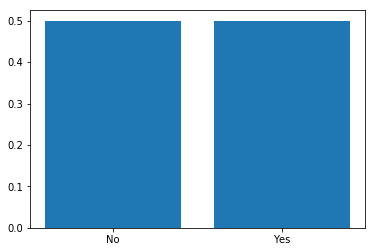

In [84]:
print('Original train data: X - {0}, y - {1}'.format(X_train_new.shape,Y_train_new.shape))
print('Balanced train data: X - {0}, y - {1}\n\n'.format(X_train_new_balanced.shape,Y_train_new_balanced.shape))
print('Output class for balanced data distribution: \n{}\n\n'.format(Y_train_new_balanced.value_counts()))
print('Output class for original data distribution: \n{}'.format(Y_train_new.value_counts()))


print('Prikaz balansiranosti izlazne varijable\n')
print(label.value_counts() / len(label))

print('\n\n\nBalanced data:')
yes_ratio_balanced = (Y_train_new_balanced.value_counts()/len(Y_train_new_balanced))[1]
no_ratio_balanced = (Y_train_new_balanced.value_counts()/len(Y_train_new_balanced))[0]

x_range_balanced = np.arange(2)
balance_class_ratio_bal = [no_ratio_balanced, yes_ratio_balanced]
fig_bal, ax_bal = plt.subplots()

plt.bar(x_range_balanced, balance_class_ratio_bal)
plt.xticks(x_range_balanced, ('No', 'Yes'))
plt.show()

In [85]:
original_cluster_0_data_x_balanced = X_train_new_balanced[X_train_new_balanced['Cluster'] == 0]
original_cluster_0_data_y_balanced = pd.DataFrame(Y_train_new_balanced.ix[Y_train_new_balanced.index.isin(original_cluster_0_data_x_balanced.index)], columns = ['y'])        

original_cluster_1_data_x_balanced = X_train_new_balanced[X_train_new_balanced['Cluster'] == 1]
original_cluster_1_data_y_balanced = Y_train_new_balanced.ix[Y_train_new_balanced.index.isin(original_cluster_1_data_x_balanced.index)]

original_cluster_2_data_x_balanced = X_train_new_balanced[X_train_new_balanced['Cluster'] == 2]
original_cluster_2_data_y_balanced = Y_train_new_balanced.ix[Y_train_new_balanced.index.isin(original_cluster_2_data_x_balanced.index)]

original_cluster_3_data_x_balanced = X_train_new_balanced[X_train_new_balanced['Cluster'] == 3]
original_cluster_3_data_y_balanced = Y_train_new_balanced.ix[Y_train_new_balanced.index.isin(original_cluster_3_data_x_balanced.index)]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecate

### Pipe za 0 klaster LR balansirani podaci

In [86]:
pipe_cluster0_steps_bal = [('stancardScaler', StandardScaler()), ('pca', PCA()), ('lr', LogisticRegression())]

pipe_cluster0_lr_pipe_bal = Pipeline(steps = pipe_cluster0_steps_bal)
pipe_cluster0_lr_pipe_bal.set_params(lr__random_state = 0)
pipe_cluster0_lr_pipe_bal.set_params(lr__class_weight = 'balanced')
pipe_cluster0_lr_pipe_bal.set_params(pca__n_components = 0.98) 

cross_validation_cluster_0_pipe_result_bal = pd.DataFrame(cross_validate(pipe_cluster0_lr_pipe_bal, original_cluster_0_data_x_balanced, original_cluster_0_data_y_balanced, cv=10, n_jobs=-1, return_train_score=True, scoring = scores))
np.mean(cross_validation_cluster_0_pipe_result_bal)

fit_time           0.027667
score_time         0.005272
test_precision     0.436215
train_precision    0.473674
test_recall        0.602252
train_recall       0.659603
test_accuracy      0.643936
train_accuracy     0.675935
test_f1            0.504498
train_f1           0.551368
dtype: float64

### Pipe za 1 klaster RANDOM FOREST balansirani podaci

In [87]:
pipe_cluster1_steps_bal = [('stancardScaler', StandardScaler()), ('pca', PCA()), ('rndf', RandomForestClassifier())]
pipe_cluster1_rndf_pipe_bal = Pipeline(steps = pipe_cluster1_steps_bal)
pipe_cluster1_rndf_pipe_bal.set_params(rndf__random_state = 0)
pipe_cluster1_rndf_pipe_bal.set_params(rndf__class_weight = 'balanced')
pipe_cluster1_rndf_pipe_bal.set_params(pca__n_components = 0.98) 

cross_validation_cluster_1_pipe_result_bal = pd.DataFrame(cross_validate(pipe_cluster1_rndf_pipe_bal, original_cluster_1_data_x_balanced, original_cluster_1_data_y_balanced, cv=10, n_jobs=-1, return_train_score=True, scoring = scores))
np.mean(cross_validation_cluster_1_pipe_result_bal)

fit_time           0.242303
score_time         0.017572
test_precision     0.943333
train_precision    1.000000
test_recall        0.850000
train_recall       1.000000
test_accuracy      0.894152
train_accuracy     1.000000
test_f1            0.881595
train_f1           1.000000
dtype: float64

### Pipe za 2 klaster KNN  balansirani podaci

In [88]:
pipe_cluster2_steps_bal = [('stancardScaler', StandardScaler()), ('pca', PCA()), ('knn', KNeighborsClassifier())]
pipe_cluster2_rndf_pipe_bal = Pipeline(steps = pipe_cluster2_steps_bal)
pipe_cluster2_rndf_pipe_bal.set_params(pca__n_components = 0.98) 

cross_validation_cluster_2_pipe_result_bal = pd.DataFrame(cross_validate(pipe_cluster2_rndf_pipe_bal, original_cluster_2_data_x_balanced, original_cluster_2_data_y_balanced, cv=10, n_jobs=-1, return_train_score=True, scoring = scores))
np.mean(cross_validation_cluster_2_pipe_result_bal)

fit_time           0.026661
score_time         0.034602
test_precision     0.670154
train_precision    0.756478
test_recall        0.984101
train_recall       0.992934
test_accuracy      0.775056
train_accuracy     0.853696
test_f1            0.796868
train_f1           0.858710
dtype: float64

### Pipe za 3 klaster GNaiveBayes balansirani podaci

In [89]:
pipe_cluster3_steps_bal = [('stancardScaler', StandardScaler()), ('pca', PCA()), ('nb', GaussianNB())]
pipe_cluster3_rndf_pipe_bal = Pipeline(steps = pipe_cluster3_steps_bal)
pipe_cluster3_rndf_pipe_bal.set_params(pca__n_components = 0.98) 

cross_validation_cluster_3_pipe_result_bal = pd.DataFrame(cross_validate(pipe_cluster3_rndf_pipe_bal, original_cluster_3_data_x_balanced, original_cluster_3_data_y_balanced, cv=10, n_jobs=-1, return_train_score=True, scoring = scores))
np.mean(cross_validation_cluster_3_pipe_result_bal)

fit_time           0.016154
score_time         0.007455
test_precision     0.481324
train_precision    0.477778
test_recall        0.775786
train_recall       0.787401
test_accuracy      0.599712
train_accuracy     0.592249
test_f1            0.592646
train_f1           0.594613
dtype: float64

# 11. Odgovorite na sledeca pitanja:
-  Na kom podskupu dobijate najbolje performanse predikcije? Na drugom podskupu (klaster 1) koristeci random forest.
- Kako se razlikuju predikcije na kompletnom test setu i na parcijalnim? Na parcijalnom setu su dosta losiji rezultati
- Koji atributi imaju najvecu prediktivnu moc?

In [90]:
varAnalisys.head(10)

,FeatureImportance,FeatureName,CumSumImportance
2,0.307097,duration,0.307097
9,0.106939,euribor3m,0.414036
10,0.065047,nr.employed,0.479083
1,0.053057,age,0.532140
6,0.036538,emp.var.rate,0.568678
8,0.036228,cons.conf.idx,0.604906
7,0.030208,cons.price.idx,0.635114
3,0.029727,campaign,0.664841
4,0.025684,pdays,0.690525
60,0.013023,poutcome_success,0.703548


- Kako se razlikuju performanse modela sa optimizovanim parametrima u odnosu na modele sa default parametrima? Modeli sa optimizovanim parametrima imaju bolje ocene.
- Da li mislite da bi neka druga kombinacija bila bolja za vas dataset i zasto? Mozda sa novim podacima dobijemo i nove ocene pa neki parametri mogu da se menjaju.
- Da li su vasi modeli pretrenirani (overfit)? verovatno da jesu jer je trening set mali

# BONUS - Pronadjite podskup atributa koji maksimizuje performanse prediktivnih algoritama. 

In [91]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest #, f_classif
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

X_train_new_resampled, Y_train_new_resampled = sm.fit_resample(X_train_new.iloc[:,:-1], Y_train_new)

### Grid search metoda sa pipelineom za algoritam RandomForest sa transformatorom SelectKBest()

In [92]:
select_kbest_pipe_steps = [('minMax', MinMaxScaler()), ('selKbest', SelectKBest()), ('rndf', RandomForestClassifier())] 
select_kbest_pipe = Pipeline(steps = select_kbest_pipe_steps)
select_kbest_pipe.set_params(selKbest__score_func = chi2)
select_kbest_pipe.set_params(rndf__random_state = 0)
select_kbest_pipe.set_params(rndf__class_weight = 'balanced')

param_grid = [
{ 
	  'rndf__n_estimators': list(range(10,30,5)), 
	  'selKbest__k': list(range(2, 60)), 
	  'rndf__min_samples_leaf': list(range(1,4)),
	  #'rndf__max_leaf_nodes': list(range(10,110,10))
}]

# pomocu grid search metode trazim najbolje parametre
search = GridSearchCV(select_kbest_pipe, param_grid, n_jobs=-1)
search.fit(X_train_new.iloc[:,:-1], Y_train_new)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.891):
{'rndf__min_samples_leaf': 1, 'rndf__n_estimators': 20, 'selKbest__k': 59}


In [93]:
select_kbest_pipe.set_params(selKbest__k = search.best_params_['selKbest__k'])
select_kbest_pipe.set_params(rndf__n_estimators = search.best_params_['rndf__n_estimators'])

# pokrecem cross validaciju
calc_result = cross_validate(select_kbest_pipe, X_train_new_resampled, Y_train_new_resampled, cv=10, n_jobs=-1, return_train_score=True, scoring = scores)
cross_validation_kbest_pipe_result = pd.DataFrame(calc_result)
np.mean(cross_validation_kbest_pipe_result)

fit_time           0.224015
score_time         0.011951
test_precision     0.991438
train_precision    1.000000
test_recall        0.880934
train_recall       0.994550
test_accuracy      0.936184
train_accuracy     0.997275
test_f1            0.888970
train_f1           0.997267
dtype: float64

Prikaz kolona KBest

In [94]:
best_k = search.best_params_['selKbest__k']
X_train_new_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X_train_new), columns = X_train_new.columns)
select_k_best = SelectKBest(score_func=chi2, k = best_k).fit(X_train_new_scaled, Y_train_new)
k_best_column_mask = select_k_best.get_support(indices=True)
features_df_new = X_train_new_scaled.iloc[:,k_best_column_mask]
print(features_df_new.columns)

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_basic.4y', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_fri', 'day_of_week_thu', 'day_of_week_t

# Hvala na paznji!